## ISMIP6 Tool of Observing Model Ranges using Clustering

Eleanor M. Byrne

### Modules 

In [12]:
# import models
%matplotlib inline
import os
import glob
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from IPython.display import display
import tkinter as tk
from plots_graphs.basemap import Base_temp_VUW_PISM, cartopy_basemap
from utils.select_dir import select_directory

### ISMIP6 Terminology

For the ISMIP6 data it consists of a few different experiments that are used for ice sheet simulations. 

| Header 1 | Header 2 | Header 3 |
|----------|----------|----------|
| Row 1, Col 1 | Row 1, Col 2 | Row 1, Col 3 |
| Row 2, Col 1 | Row 2, Col 2 | Row 2, Col 3 |
| Row 3, Col 1 | Row 3, Col 2 | Row 3, Col 3 |

### The NetCDF Files
<h5 id="C5">[5]</h5>

In [10]:
select_directory()

In [2]:
# Specify the directory path and know what the directory path is
directory = "C:/Users/Margo/OneDrive/Documents/ISMIP_ResearchThesis"
# Check if the folder exists
if os.path.exists(directory) and os.path.isdir(directory):
    print(f"The folder at '{directory}' exists.")
else:
    print(f"The folder at '{directory}' does not exist or is not a directory.")

The folder at 'C:/Users/Margo/OneDrive/Documents/ISMIP_ResearchThesis' exists.


In [ ]:
''' I will be opening the nc files to 
understand what they contain. 
Since they are netcdf files I will need to 'import netCDF4'
'''
base_temp_VUW_PISM = nc.Dataset('/home/theghub/embyrne/Research/ISMIP6 Data/litempbotgr_GIS_VUW_PISM_ctrl_proj.nc')
base_temp_UAF_PISM2 =nc.Dataset('/home/theghub/embyrne/Research/ISMIP6 Data/litempbotgr_GIS_UAF_PISM2_ctrl_proj.nc')
base_temp_UCIJPL_ISSM1 =nc.Dataset('/home/theghub/embyrne/Research/ISMIP6 Data/litempbotgr_GIS_UCIJPL_ISSM1_ctrl_proj.nc')
base_temp_UCIJPL_ISSM2 =nc.Dataset('/home/theghub/embyrne/Research/ISMIP6 Data/litempbotgr_GIS_UCIJPL_ISSM2_ctrl_proj.nc')
bed_VUW_PISM = nc.Dataset('/home/theghub/embyrne/Research/ISMIP6 Data/topg_GIS_VUW_PISM_ctrl_proj.nc')
iceT_VUW_PISM = nc.Dataset('/home/theghub/embyrne/Research/ISMIP6 Data/lithk_GIS_VUW_PISM_ctrl_proj.nc')

### Mapping Greenland with Cartopy <h5 id="C8">[8]</h5> 
I will be mapping Greenland using Cartopgy and the ccrs.Orthographic. This allows a "bird's-eye view" of Greenland.

### Adding in the Data
Now that the basemap has been created, it is time to add the data that needs to be plotted

In [ ]:
# base_temp_VUW_PISM
lon_VP = base_temp_VUW_PISM['lon'][:]
lat_VP = base_temp_VUW_PISM['lat'][:]
base_VP = base_temp_VUW_PISM['litempbotgr'][0:]
label_VP = 'Temp beneath grounded ice sheet'

# base_temp_UAF_PISM2
lon_UP = base_temp_UAF_PISM2['lon'][:]
lat_UP = base_temp_UAF_PISM2['lat'][:]
base_UP = base_temp_UAF_PISM2['litempbotgr'][0:]
label_UP = 'Temp beneath grounded ice sheet'

# base_temp_UCIJPL_ISSM1
lon_UI = base_temp_UCIJPL_ISSM1['lon'][:]
lat_UI = base_temp_UCIJPL_ISSM1['lat'][:]
base_UI = base_temp_UCIJPL_ISSM1['litempbotgr'][0:]
label_UI = 'Temp beneath grounded ice sheet'

# base_temp_UCIJPL_ISSM2
lon_UI2 =  base_temp_UCIJPL_ISSM2['lon'][:]
lat_UI2 =  base_temp_UCIJPL_ISSM2['lat'][:]
base_UI2 =  base_temp_UCIJPL_ISSM2['litempbotgr'][0:]
label_UI2 = 'Temp beneath grounded ice sheet'

# bed_VUW_PISM
lon_b_VP =  bed_VUW_PISM['lon'][:]
lat_b_VP =  bed_VUW_PISM['lat'][:]
base_b_VP =  bed_VUW_PISM['topg'][0:]
label_b_VP = 'Bedrock elevation'

# iceT_VUW_PISM
lon_iT_VP =  iceT_VUW_PISM['lon'][:]
lat_iT_VP =  iceT_VUW_PISM['lat'][:]
base_iT_VP =  iceT_VUW_PISM['lithk'][0:]

C:\Users\Margo\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
C:\Users\Margo\anaconda3\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


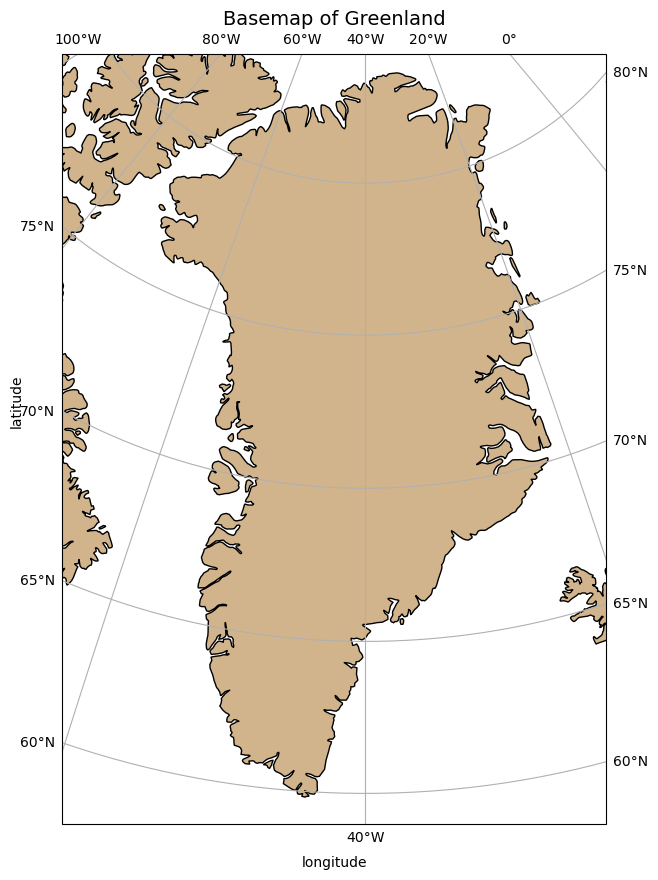

In [11]:
cartopy_basemap()

In [ ]:
cartopy_basemap(lon_VP, lat_VP, base_VP, label_VP)

In [ ]:
cartopy_basemap(lon_UP, lat_UP, base_UP, label_UP)

In [ ]:
cartopy_basemap(lon_UI, lat_UI, base_UI)

In [ ]:
cartopy_basemap(lon_UI2, lat_UI2, base_UI2, label_UI2)

In [ ]:
cartopy_basemap(lon_iT_VP, lat_iT_VP, base_iT_VP)

In [ ]:
cartopy_basemap(lon_b_VP, lat_b_VP, base_b_VP, label_b_VP)

### Processing Data

### Plotting and Graphs 

### Elbow Method

### K-Means Clustering

### Results 

### References/Sources
Used for mentioning papers, github, and other sites to find code sources or additonal information

* <h5 id="C1">[1]</h5><a href="https://www.climate-cryosphere.org/wiki/index.php?title=ISMIP6-Projections-Antarctica ">Cryosphere Climate Antartica</a>  Used for terminology and understanding the functionanilty of the ISMIP6 projections.
* <h5 id="C2">[2]</h5> <a href="https://www.climate-cryosphere.org/wiki/index.php?title=ISMIP6-Projections-Greenland">Cryosphere Climate Greenland</a>: Used for terminology and understanding the functionanilty of the ISMIP6 projections.
* <h5 id="C3">[3]</h5> <a href="https://chat.openai.com/auth/login?iss=https%3A%2F%2Fauth0.openai.com%2F">ChatGPT</a>: Used for converting matlab code into usable python code and additional code edits. 
* <h5 id="C4">[4]</h5> <a href="https://github.com/hgoelzer-ismip6/ismip6-gris-analysis">ISMIP6 Analysis Github</a>: Scripts for the plotting of ISMIP6 Greenland projections created by hgeolzer. Matlab scripts were converted into python by Eleanor M. Byrne using ChatGPT and other resources found. 
* <h5 id="C5">[5]</h5> <a href="https://realpython.com/working-with-files-in-python/">Working with Files in Python</a>: Website with helpful tips of viewing files. 
* <h5 id="C6">[6]</h5> <a href="https://theghub.org/groups/ismip6/wiki/MainPage">ISMIP6 Ghub</a>:Webpage on Ghub. 
* <h5 id="C7">[7]</h5> <a href="https://www.pism.io/docs/manual/practical-usage/ismip6.html#tab-ismip6-variables">ISMIP6_Term</a>
* <h5 id="C8">[8]</h5> <a href="https://scitools.org.uk/cartopy/docs/latest/matplotlib/intro.html#adding-data-to-the-map">Cartopy</a> Used this for creating a base map of Greenland to plot the data found. 